# Notebook para o PAN - Atribuição Autoral - 2018 - Final 2019

In [1]:
%matplotlib inline

python basic libs

In [2]:
#python basic libs
import os;
from os.path import join as pathjoin;
import zipfile;

import re;
import random;
import json;
from collections import defaultdict;
from pprint import pprint
from time import time

In [3]:
#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;


import seaborn as sns;

In [4]:
#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import feature_selection;

#preprocessing and transformation
from sklearn import preprocessing;
from sklearn.preprocessing import MaxAbsScaler;
from sklearn.decomposition import PCA;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression


#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score;

NLP libraries

In [5]:
import spacy;
import gensim
import logging
from gensim.models import KeyedVectors
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [6]:
from IPython.display import Markdown, display, HTML

libraries configurations

In [7]:

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format
sns.set(color_codes=True);

In [9]:
import platform;
import sklearn;
import scipy;

Markdown(
    "|%-15s|%-65s|\n"%("PACK","VERSION") +
    "|%-15s|%-65s|\n"%('-'*15,'-'*65) +
    ('\n'.join(
    "|%-15s|%-45s| " % (pack, version.strip())
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn','Spacy','Gensim'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__, spacy.__version__, gensim.__version__])

)))

|PACK           |VERSION                                                          |
|---------------|-----------------------------------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit              | 
|NumPy          |1.15.4                                       | 
|SciPy          |1.1.0                                        | 
|Scikit-Learn   |0.20.1                                       | 
|Seaborn        |0.9.0                                        | 
|Spacy          |2.0.16                                       | 
|Gensim         |3.4.0                                        | 

### paths configuration

### on google

from google.colab import drive
drive.mount('/gdrive')

!ls '/gdrive/My Drive/data_repository'

baseDir = '/gdrive/My Drive/data_repository';
modelName = 'char1';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',modelName);

os.makedirs(outputDir, exist_ok=True)


def transferCode(filename):
    with open(os.path.join('/gdrive/My Drive','Colab Notebooks',filename)) as fin:
        with open(filename,'w') as fout:
            fout.write(fin.read());

transferCode('pan.py')
transferCode('sklearnExtensions.py')

!ls 

### on local

In [10]:
baseDir = '/Users/joseeleandrocustodio/dataScienceNotebook/PANAA2018';

corpusTraining    = 'pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02';
corpusEvaluation = 'pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20';
corpusEach1 = 'AvaliacaoPT';

currentCorpus = corpusEach1;

inputDir= pathjoin(baseDir,currentCorpus);
outputDir= pathjoin(baseDir,'out');
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## Data Ingestion

In [11]:
import pan
import sklearnExtensions
from sklearnExtensions import DenseTransformer, POSTagTransformer, FilterTagTransformer

In [12]:
problems = pan.readCollectionsOfProblems(inputDir);

In [13]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,[[O sol da noite agora está nascendo\nAlguma c...,5,UTF-8,pt,problem00001,[[Não me pergunte por que\nQuem-Como-Onde-Qual...
1,[[O que é que pode fazer o homem comum\nNeste ...,10,UTF-8,pt,problem00002,[[Te vejo errando e isso não é pecado\nExceto ...
2,[[O que é que pode fazer o homem comum\nNeste ...,15,UTF-8,pt,problem00003,"[[Ou Campo Grande, ou Cuiabá\nNão sei se eu fi..."
3,[[Fui ver\nAchei que engordei alguns quilinhos...,20,UTF-8,pt,problem00004,"[[Eu Geminiano, essa mina é virgem\nMesmo assi..."
4,[[O sol da noite agora está nascendo\nAlguma c...,30,UTF-8,pt,problem00005,[[O meu é bem maior que do namorado seu\nApost...
5,"[[Some were reborn,\nSome were simply shaken f...",5,UTF-8,en,problem00006,[[She'd do anything to sparkle in his eye\nshe...
6,[[Chasing down a wild fire\nAre you trying to ...,10,UTF-8,en,problem00007,"[[Just a day, just an ordinary day\nJust tryin..."
7,[[Mum mum mum mah\nMum mum mum mah\nMum mum mu...,15,UTF-8,en,problem00008,[[You make me nervous when you're flying aroun...
8,[[You've got to learn \nTo brighten up your wa...,20,UTF-8,en,problem00009,[[She invited me to a pity party\nEvery hour e...
9,"[[Konvict (Konvict)\nOhhh, ohh, ohh, ohh\nJust...",30,UTF-8,en,problem00010,[[I'll give you countless amounts\nOf outright...


# Caching embeddings and POS Tagging

### Linguistic anotations

In [14]:
def cachingPOSTAG(problem, corpusName, taggingVersion='TAG',verbose=False):
    import json;
    if verbose:
        print ("Tagging: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    pos_cache_dir = pathjoin('POSTAG_cache',corpusName);
    
    if not os.path.exists(pos_cache_dir):
        os.makedirs(pos_cache_dir);
    
    _id = problem['problem']+problem['language'];
    filename = os.path.join(pos_cache_dir,taggingVersion+'_'+_id+'.json')
    if not os.path.exists(filename):
        lang = problem['language'];
        if lang == 'sp':
            lang = 'es';
        elif lang =='pl':
            print(lang, ' not supported');
            return ;

        train_docs, train_labels, _   = zip(*problem['candidates'])
        problem['training_docs_size'] = len(train_docs);
        test_docs, _, test_filename   = zip(*problem['unknown'])

        t0 = time()
        tagger = POSTagTransformer(language=lang);
        train_docs = tagger.fit_transform(train_docs);
        test_docs = tagger.fit_transform(test_docs);
        
        print("Annotation time %0.3fs" % (time() - t0))
        
        with open(filename,'w') as f:
            json.dump({
                'train':train_docs,
                'train_labels':train_labels,
                'test':test_docs,
                'test_filename':test_filename
            },f);
    else:
        with open(filename,'r') as f:
            data = json.load(f);

            train_docs = data['train'];
            train_labels = data['train_labels'];
            test_docs  = data['test'];
            test_filename = data['test_filename'];
    if verbose:
        print('tagged')
    return train_docs, train_labels, test_docs, test_filename;

for problem in problems:
    cachingPOSTAG(problem,currentCorpus,verbose=True)

Tagging: problem00001,  language: pt,  Annotation time 11.555s
tagged
Tagging: problem00002,  language: pt,  Annotation time 20.489s
tagged
Tagging: problem00003,  language: pt,  Annotation time 36.590s
tagged
Tagging: problem00004,  language: pt,  Annotation time 54.963s
tagged
Tagging: problem00005,  language: pt,  Annotation time 69.473s
tagged
Tagging: problem00006,  language: en,  Annotation time 7.662s
tagged
Tagging: problem00007,  language: en,  Annotation time 12.804s
tagged
Tagging: problem00008,  language: en,  Annotation time 25.543s
tagged
Tagging: problem00009,  language: en,  Annotation time 27.907s
tagged
Tagging: problem00010,  language: en,  Annotation time 54.271s
tagged


### Embeddings

In [15]:
def loadEmbeddings(lang):
    if lang == 'sp':
        lang = 'es';
    model = KeyedVectors.load_word2vec_format(os.path.join('embedding_cache','w2v_en.txt.gz'), binary=False, unicode_errors='replace')
    return model;

In [16]:
regex_cleaning = [re.compile(w) for w in[
    r'[\u4E00-\u9FA5]+',  #chinese,
    r'[\u3040-\u309F]+'  #hiragana
]]

In [17]:
def problemDoc(problem):
    train_docs, train_labels, _   = zip(*problem['candidates'])
    test_docs, _, test_filename   = zip(*problem['unknown']);
    test_labels = pan.readGroundTruh(pathjoin(inputDir, problem['problem'], 'ground-truth.json'),test_filename)
    return train_docs, train_labels, test_docs, test_labels,test_filename;

In [18]:
def problemsToTokens(problems):
    def clean(d):
        for r in regex_cleaning:
            d = r.sub('',d);
        return d;
    tokens = {};
    pattern = re.compile(r"(?u)\b\w\w+\b");
    for problem in problems:
        lang = problem['language'];
        if lang == 'sp':
            lang = 'es';
        train_docs, _, test_docs, _, _ = problemDoc(problem);
        docs = list(train_docs)+list(test_docs);

        if lang not in tokens:
            tokens[lang] = list();
        tokens[lang] +=list(set([w  for d in docs for w in pattern.findall(clean(d))]));
        tokens[lang] = sorted(list(set(tokens[lang])));
    return tokens;

In [19]:
def inspect():
    tokens = problemsToTokens(problems)
    for k,v in tokens.items():
        s = random.randint(0,len(v));
        print(k,len(v), v[s:(s+5)])
inspect();

pt 23194 ['convençam', 'convenço', 'conversa', 'conversamos', 'conversando']
en 18541 ['ozark', 'ozone', 'pa', 'pace', 'paced']


It was used embeddings processed by Nordic Language Processing Laboratry 
and availabe on http://vectors.nlpl.eu/repository/. This website was visted in  jan 01 2019

In [20]:
def outputAnswer(test_pred,test_filename,answerFile):
    # Writing output file using the same format as PAN 
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)

In [21]:
def fitPipeline(pipe,params,problem,corpus,caching=None):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ');
    
    if caching == 'POS':
        if problem['language'] == 'pl':
            print("POS tagger not found")
            return {
                'problem':problem['problem'],
                'language':problem['language'],
                'n_authors': 0,
                'f1'       : 0,
                'precision': 0,
                'recall'   : 0,
                'accuracy' : 0,
            }, [], [], [], {};
        else:
            train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem,corpus);
    elif caching == 'w2v':
        global embeddingsCacheLanguage;
        global embeddingsCache;
        #yes it is uggly to use global var ... but it saved a lot of memory
        if embeddingsCacheLanguage != problem['language']:
            embeddingsCache = loadEmbeddings(problem['language']);
            embeddingsCacheLanguage = problem['language'];
        train_docs, train_labels, test_docs, test_labels,test_filename = problemDoc(problem);
    else:
        train_docs, train_labels, test_docs, test_labels,test_filename = problemDoc(problem);
    
    #using language specific params
    if problem['language'] in params:
        pipe.set_params(**params[problem['language']])
        
    t0 = time()
    pipe.fit(train_docs, train_labels)
    print("Fitted in %0.3fs" % (time() - t0), end=' ');
    
    t0 = time()
    test_pred=pipe.predict(test_docs);
    train_prob=pipe.predict_proba(train_docs);
    test_prob=pipe.predict_proba(test_docs);
    print("Predicted in %0.3fs" % (time() - t0));
    
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    outputAnswer(test_pred,test_filename,answerFile)
    
    #calculating the performance using PAN evaluation code
    grountTruthFile = pathjoin(inputDir, problem['problem'], 'ground-truth.json');
    f1,precision,recall,accuracy=pan.evaluate(grountTruthFile,answerFile);
    
    
    return {
        'problem':problem['problem'],
        'language':problem['language'],
        'n_authors':len(set(train_labels)),
        'f1'       : round(f1,3),
        'precision': round(precision,3),
        'recall'   : round(recall,3),
        'accuracy' : round(accuracy,3),
    }, test_pred, train_prob, test_prob, pipe.get_params();

# Model 1: Character

In [22]:
pipelineChar = Pipeline([
    ('vect',   TfidfVectorizer(analyzer='char',
                               min_df=0.01,
                               max_df=1.0,
                               norm='l2',
                               ngram_range=(2, 5),
                               sublinear_tf=True,
                               lowercase =False)),
    ('scaler', preprocessing.MaxAbsScaler()),
    ('dense',  DenseTransformer()),
    ('transf', PCA(0.999)),
    ('clf', linear_model.LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
])

In [23]:
pipelineCharParams= {
    'it':{
        'vect__ngram_range': (3, 5),
    },
    'pl':{
        'vect__ngram_range': (2, 3),
    }
}

# Model 2: Word

In [24]:
pipelineWord = Pipeline([
    ('vect',   TfidfVectorizer(analyzer='word',
                               norm='l1',
                               min_df=2,
                               max_df=1.0,
                               ngram_range=(1, 2),
                               smooth_idf=True,
                               lowercase =True,
                               sublinear_tf=True)),
    ('dense',  DenseTransformer()),
    ('scaler', preprocessing.MaxAbsScaler()),
    ('transf', PCA(0.999)),
    ('clf', linear_model.LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
])

In [25]:
pipelineWordParams= {
    'en':{
        'vect__ngram_range': (1, 3),
        'vect__norm': 'l2',
    },

    'pl':{
        'vect__norm': 'l2',
     },
}


# Model 3: distortions

In [26]:
distortions = [
    (r"[A-Z]"          ,'U','Upcase '),
    (r"[a-z]"          ,'l','lowercase'),
    (r"[À-ÿĄ-ż]"       ,'d','Diacrit'),
    (r"\d"             ,'D','Digits'),
    (r"[\n\r\t]"       ,'E','Paragraph control'),
    (r"\–|\-|\_|\—"    ,'H','Hyphen'),
    (r"\"|\'|’|[“”]"   ,'Q','quotation'),
    (r"\s"             ,'S','Spaces'),
    (r"\(|\)|\[|\]\{|\}|\«|\»",'G','Groups'),
    (r"…",'','...'),
    (r"\.|\,|[?]|\!|\:|\;|\„|\*|\/"   ,'P','Punctuation'),
    (r"[^aUldDEHQSGP]", 'X','Unkown'),
]

distortions = [(re.compile(d[0]), d[1],d[2]) for d in distortions]

In [27]:
class DistortionTransformer(BaseEstimator):
    def __init__(self,verbose=False):
        self.verbose = verbose;
        
    def _distortion(self,doc):
        for d in distortions:
            doc = d[0].sub(d[1],doc);
        return doc;

    def transform(self, X, y=None):
        t0 = time()
        if self.verbose:
            print('filtered in', end=' ')

        X = [self._distortion(doc) for doc in X]
        
        if self.verbose:
            print(" %0.3fs" % (time() - t0))
        return np.array(X);       

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [28]:
pipelineDistortion = Pipeline([
    ('filter',DistortionTransformer()),
    ('vect', TfidfVectorizer(
            analyzer='char',
            min_df=0.01,
            lowercase=False,
            norm='l2',
            sublinear_tf=True,
            ngram_range=(1, 5),
            )
    ),
    ('scaler', MaxAbsScaler()),
    ('dense',  DenseTransformer()),
    ('transf', PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,C=1,multi_class='multinomial', solver='newton-cg')),
])

In [29]:
pipelineDistortionsParams = {
    'en':{
        'clf__C': 0.1,
        'vect__norm': 'l1',        
    },
    'fr':{
        'vect__norm': 'l1',
        'vect__ngram_range': (2, 5),
    },
    'it':{
        'clf__C': 0.1,
    },
    'sp':{
        'vect__norm': 'l1',
    }
}

# Model 4: POS

In [30]:
#train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

pipelinePOS = Pipeline([
    ('filter',FilterTagTransformer(token='POS')),
    ('vect', TfidfVectorizer(
                        min_df=0.01,
                        lowercase=False,
                        use_idf=True,
                        norm='l1',
                        sublinear_tf=False,
                        ngram_range=(1, 5)
            )),
    ('scaler', MaxAbsScaler()),
    ('dense',  DenseTransformer()),
    ('transf', PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
])

O parametro sublinear_tf=True apresentou performance ruim em todos os casos de teste exceto o melhor.
Como o melhor caso não é garantido nos conjuntos de avaliação, foi decidido que ele seria mantido como False.

O parametro L1 apresentou performance melhor nos conjuntos com 5 candidatos. No entendo, o conjunto de validação conterá de 5 a 20 e portanto foi escolhido manter o valor l2

# Model 5: TAG  (granular POS)

In [31]:
def spaceTokenizer(x):
    return x.split(" ");

In [32]:
pipelineTag = Pipeline([
    ('filter',FilterTagTransformer(token='TAG')),
    ('vect', TfidfVectorizer(
                               tokenizer=spaceTokenizer,
                               min_df=0.01,
                               lowercase=False,
                               sublinear_tf=True,
                               use_idf=True,
                               norm='l2',
                                ngram_range=(1,3),
                              )),
    ('scaler', MaxAbsScaler()),
    ('dense',  DenseTransformer()),
    ('transf', PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,C=0.1,multi_class='multinomial', solver='newton-cg')),
])

In [33]:
pipelineTagParams = {
    'fr':{
        'vect__ngram_range' :(1,5),
    },
    'sp':{
        'vect__ngram_range' :(1,5),
        'clf__C':1,
    }
}

# Model 6: Sintatic Dependency

In [34]:
pipelineDEP = Pipeline([
    ('filter',FilterTagTransformer(token='DEP')),
    ('vect', TfidfVectorizer(
                    analyzer='word',
                    min_df=0.01,
                    lowercase=False,
                    use_idf=True,
                    norm='l2',
                    ngram_range=(1,5),
            )),
    ('scaler', MaxAbsScaler()),
    ('dense',  DenseTransformer()),
    ('transf', PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,C=1,multi_class='multinomial', solver='newton-cg')),
])

In [35]:
pipelineDEPParams = {
    'en':{
        'clf__C':0.1,
    },
    'fr':{
        'clf__C':0.1,
    },
    'it':{
        'vect__ngram_range' :(1,3),
    },
}

# Model 7 : Char with POS filter

en1['PUNCT', 'PROPN', 'VERB', 'NOUN', 'ADV', 'ADJ', 'ADP', 'INTJ', 'PRON', 'DET', 'CCONJ', 'NUM', 'PART']
en2['PUNCT', 'VERB', 'ADV', 'PROPN', 'NOUN', 'NUM', 'ADJ', 'PRON', 'INTJ', 'ADP', 'PART', 'DET', 'CCONJ']

fr1['NOUN', 'VERB', 'PROPN', 'ADV', 'ADJ', 'PRON', 'PUNCT', 'ADP', 'DET', 'AUX', 'CCONJ', 'X', 'SCONJ', 'NUM']
fr2['NOUN', 'ADV', 'VERB', 'PROPN', 'ADJ', 'X', 'SCONJ', 'DET', 'PRON', 'AUX', 'CCONJ', 'PUNCT', 'NUM', 'ADP']

it1['VERB', 'NOUN', 'PUNCT', 'PROPN', 'ADV', 'ADJ', 'PRON', 'DET', 'SCONJ', 'AUX', 'CONJ', 'X', 'ADP', 'INTJ', 'NUM']
it2['VERB', 'PROPN', 'PUNCT', 'ADV', 'NOUN', 'PRON', 'SCONJ', 'AUX', 'ADJ', 'NUM', 'CONJ', 'DET', 'INTJ', 'ADP', 'X']

sp1['PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'ADV', 'PRON', 'AUX', 'SCONJ', 'ADP', 'CONJ', 'DET', 'INTJ', 'NUM']
sp2['PROPN', 'VERB', 'NOUN', 'ADJ', 'ADV', 'SCONJ', 'ADP', 'PUNCT', 'PRON', 'DET', 'CONJ', 'AUX', 'NUM', 'INTJ']


In [36]:
#train_docs, train_labels, test_docs, test_filename = cachingPOSTAG(problem)

pipelineCharFilter = Pipeline([
    ('filter',FilterTagTransformer(token='filter')),
    ('vect', TfidfVectorizer(
            analyzer='char_wb',
            min_df=0.01,
            lowercase=False,
            ngram_range=(2,5),
            norm='l2',sublinear_tf=True
        )
    ),
    ('scaler', MaxAbsScaler()),
    ('dense',  DenseTransformer()),
    ('transf', PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
])

In [37]:
pipelineCharFilterParams = {
    'en':{
        'filter__parts': ['PUNCT', 'PROPN', 'VERB', 'NOUN', 'ADV', 'ADJ', 'ADP', 'INTJ', 'PRON', 'DET', 'CCONJ', 'NUM', 'PART']
    },
    'fr':{
        'filter__parts': ['NOUN', 'ADV', 'VERB', 'PROPN', 'ADJ', 'X', 'SCONJ', 'DET', 'PRON', 'AUX', 'CCONJ', 'PUNCT']
    },
    'it':{
        'filter__parts': ['VERB', 'NOUN', 'PUNCT', 'PROPN', 'ADV', 'ADJ', 'PRON']
    },
    'pt':{
        'filter__parts': ['PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'ADV', 'PRON', 'AUX', 'SCONJ', 'ADP', 'CONJ', 'DET']
    }
}

# Model 8: Word Embeddings

In [38]:
embeddingsCacheLanguage = None;
embeddingsCache = None;

In [47]:
from scipy import sparse
from sklearn.utils import assert_all_finite

class EmbeddingVectorizer(BaseEstimator):
    def __init__(self,norm=None,analyzer='word',min_df=1,lowercase=False,sublinear_tf=True,use_idf=True,binary=False):
        self.norm        = norm;
        self.analyzer    = analyzer;
        self.min_df      = min_df;
        self.lowercase   = lowercase;
        self.sublinear_tf= sublinear_tf;
        self.use_idf     = use_idf;
        self.binary      = binary;
        
    def fit(self, X, y=None):
        self.dim_ = len(embeddingsCache.vectors[0]);
        #self.dim_ = len(embeddingsCache[list(embeddingsCache.keys())[0]])
        self.vect = TfidfVectorizer(**self.get_params())
        self.vect.fit(X,y);
        self.word_vectors_ = np.zeros((len(self.vect.vocabulary_), self.dim_));
        
        #this arrays says if a word in the vocab has 
        self.missingWord_  = np.zeros(len(self.vect.vocabulary_),dtype=np.int8);
        
        blank = np.zeros(self.dim_);

        for  word, index in self.vect.vocabulary_.items():
            temp = blank.copy();
            for w in [word, word.lower(), word.capitalize()]:
                if w in embeddingsCache:
                    temp = embeddingsCache[w];
                    break;
            if temp.sum() == 0 :
                self.missingWord_[index] = 1;
            self.word_vectors_[index,:] = temp;
        return self
    
    def transform(self, X):
        import gc;
        gc.collect()
        X = self.vect.transform(X);
        
        X = sparse.csc_matrix(X);
        V = sparse.csc_matrix(self.word_vectors_);
        M = sparse.csc_matrix(self.missingWord_).T;
        
        missing = preprocessing.normalize((X>0).dot(M),norm='l1');
        missing = sparse.csc_matrix(missing.reshape(-1,1));
        
        #memory friendly dot product
        X  = preprocessing.normalize(X.dot(V),norm='l1');
        
        #last columns will contain the embedding coverage
        X = sparse.hstack([X,missing]);
        
        return X;
    
    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X)
    
    def get_feature_names():
        return self.vect.get_feature_names();

In [48]:
pipelineEmbeddings = Pipeline([
    ('vect', EmbeddingVectorizer(
            analyzer='word',
            min_df=0.01,
            lowercase=False,
            sublinear_tf=False,
            norm='l1',
            use_idf=False
            )
    ),
    ('scaler',preprocessing.MaxAbsScaler()),
    ('dense',DenseTransformer()),
    ('pca',PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,C=1,multi_class='multinomial', solver='newton-cg')),
])

In [41]:
pipelineEmbeddingsParams = {
    'fr':{
        'vect__sublinear_tf': True,
        'vect__use_idf': True,
    },

    'it':{
        'vect__use_idf': True,
    },

    'pl':{
        'clf__C': 0.1,
        'vect__use_idf': False,
        'vect__sublinear_tf': True,
    },
    'sp':{
        'vect__sublinear_tf': True,
        'vect__use_idf': True,
    },
}

# Applying models

In [44]:
results = {};

In [49]:
models =[
    ('char',pipelineChar,pipelineCharParams,None),
    ('word',pipelineWord,pipelineWordParams,None),
    ('dist',pipelineDistortion,pipelineDistortionsParams,None),
    ('pos',pipelinePOS,{},'POS'),
    ('tag',pipelineTag,pipelineTagParams,'POS'),
    ('dep',pipelineDEP,pipelineDEPParams,'POS'),
    ('charFilter',pipelineCharFilter,pipelineCharFilterParams,'POS'),
    ('w2v',pipelineEmbeddings,pipelineEmbeddingsParams,'w2v'),
]

for model in models:
    if model[0] in results:
        continue;
    print(('_'*100)+'\n'+model[0]+'\n'+('_'*100))
    result= {
        'metric':[],
        'pred':[],
        'prob_train':[],
        'prob_test':[],
        'params':[],
    }
    for problem in problems:
        metric, pred, prob_train, prob_test, params = fitPipeline(model[1], model[2],problem, caching=model[3],corpus=currentCorpus);
        result['metric'].append(metric);
        result['pred'].append(pred);
        result['prob_train'].append(prob_train);
        result['prob_test'].append(prob_test);
        result['params'].append(params);
    results[model[0]]=result;
os.system( "say finished" )

____________________________________________________________________________________________________
w2v
____________________________________________________________________________________________________
Problem: problem00001,  language: pt,  Fitted in 0.269s Predicted in 0.398s
Problem: problem00002,  language: pt,  Fitted in 0.266s Predicted in 0.387s
Problem: problem00003,  language: pt,  Fitted in 0.319s Predicted in 0.454s
Problem: problem00004,  language: pt,  Fitted in 0.348s Predicted in 0.471s
Problem: problem00005,  language: pt,  Fitted in 0.439s Predicted in 0.544s
Problem: problem00006,  language: en,  Fitted in 0.226s Predicted in 0.424s
Problem: problem00007,  language: en,  Fitted in 0.238s Predicted in 0.433s
Problem: problem00008,  language: en,  Fitted in 0.303s Predicted in 0.494s
Problem: problem00009,  language: en,  Fitted in 0.359s Predicted in 0.589s
Problem: problem00010,  language: en,  Fitted in 0.714s Predicted in 0.769s


0

In [50]:
dfMetric = pd.DataFrame();
for m in results:
    df = pd.DataFrame(results[m]['metric'])[['problem','n_authors','language','f1','precision','recall','accuracy']]
    df['model']=m
    dfMetric= dfMetric.append(df)
    
dfMetric.fillna(value=0) \
    .pivot(index='problem',columns='model',values=['f1','accuracy'])\
    .style.background_gradient(subset=['f1'], axis=1, cmap=plt.cm.Blues)\
    .background_gradient(subset=['accuracy'], axis=1, cmap=plt.cm.Greens)

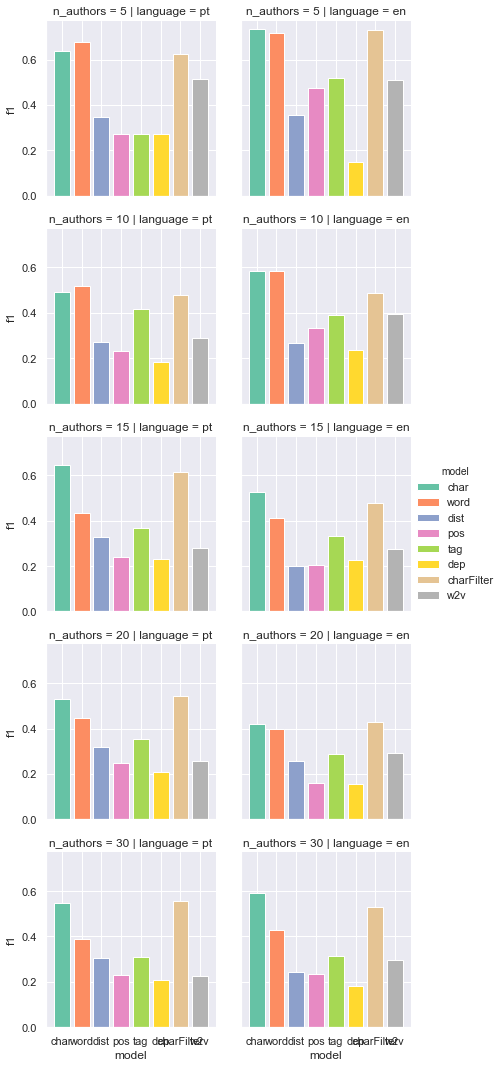

In [51]:
dfMetric = dfMetric[dfMetric.n_authors.values != 0]
dfMetric['id'] = dfMetric.problem.apply(lambda x: int(re.sub('\D','',x)))
g = sns.FacetGrid(dfMetric, row='n_authors',  col="language", hue='model', height=3,palette="Set2")
g.map(plt.bar, "model", "f1").add_legend();

import pickle;
with open("PANAA18.json","wb") as f:
    pickle.dump(results,f)

In [52]:
def readGroundTruth():
    gt_train = [];
    gt_test = [];
    for problem in problems:
        _, train_labels, _, test_labels,_ = problemDoc(problem);
        gt_train.append(np.array(train_labels));
        gt_test.append(np.array(test_labels));
    return gt_train, gt_test;
groundTruthTrain, groundTruth = readGroundTruth()

In [53]:
data = PCA(2).fit(
    preprocessing.normalize(results['pos']['prob_train'][0])
).transform(
    preprocessing.normalize(results['char']['prob_test'][0])
);

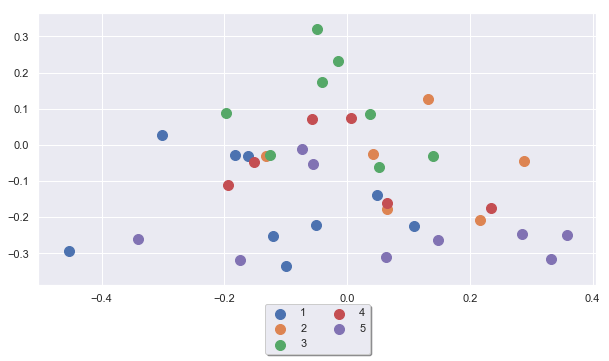

In [71]:
plt.figure(figsize=(10,5))
for label in sorted(set(groundTruth[0])):
    _filter = groundTruth[0] ==label;
    plt.scatter(data[_filter,0],data[_filter,1], label=re.sub('\D+0+','',label),s=100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=int(len(set(groundTruth[0]))*0.50));

# mixed model

In [74]:
problemIndex = 0;
x_train = np.hstack([results[model]['prob_train'][problemIndex] for model in results])
x_test  = np.hstack([results[model]['prob_test'][problemIndex] for model in results])

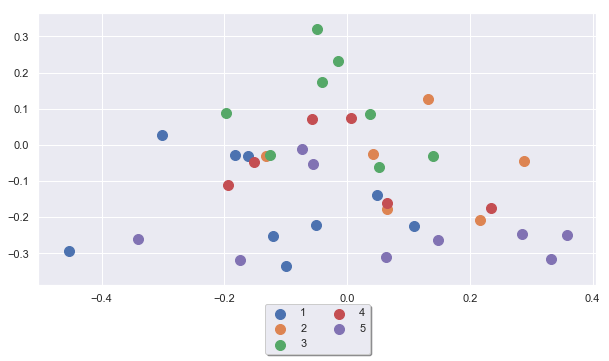

In [75]:
data = PCA(2).fit(
    preprocessing.normalize(x_train)
).transform(
    preprocessing.normalize(x_test)
);

plt.figure(figsize=(10,5))
for label in sorted(set(groundTruth[0])):
    _filter = groundTruth[0] ==label;
    plt.scatter(data[_filter,0],data[_filter,1], label=re.sub('\D+0+','',label),s=100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=int(len(set(groundTruth[0]))*0.50));

In [58]:
pipelineFinal = Pipeline(steps=[
    #('normalization',preprocessing.MaxAbsScaler()),
    ('pca',PCA(0.9999)),
    ('clf', LogisticRegression(random_state=0,C=100000))
])

pipelineFinal.fit(x_train, groundTruthTrain[problemIndex]);
pred_label = pipelineFinal.predict(x_test);

In [59]:
f1_score(groundTruth[problemIndex],pred_label,average='macro')

0.6347420695246783

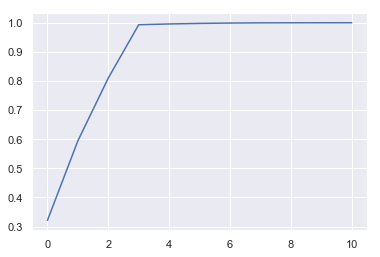

In [60]:
plt.plot(pipelineFinal.steps[0][1].explained_variance_ratio_.cumsum())

In [61]:
def buildX(results,problemIndex, models):
    x_train = [results[model]['prob_train'][problemIndex] for model in models];
    x_test  = [results[model]['prob_test'][problemIndex] for model in models];
    
    x_train = [x for x in x_train if len(x) > 1];
    x_test  = [x for x in x_test  if len(x) > 1];
    
    if len(x_train) < 1:
        return None,None;
    
    return np.hstack(x_train), np.hstack(x_test);

def buildClassifier():
    return Pipeline(steps=[
                ('pca',PCA(0.9999)),
                ('clf', LogisticRegression(random_state=0,C=1))
            ])

def sortModels(results,problemIndex,models):
    f1 = [];
    
    for model in models:
        x_train, x_test = buildX(results, problemIndex, [model]);
        if x_train is None:
            f1.append(0); #dammit pl
        else:
            pipe = buildClassifier()
            pred_label = pipe.fit(x_train, groundTruthTrain[problemIndex]).predict(x_test);
            f1.append(f1_score(groundTruth[problemIndex],pred_label,average='macro'));
    models = np.array(models);
    f1 = np.array(f1);
    
    models = models[f1 >0];
    f1 = f1[f1 >0]
    
    return list(models[np.argsort(-f1)]);
    

resultFinal = []
bestModels = []
for problemIndex, problem in enumerate(problems):
    print('\n'+problem['problem']+' '+problem['language'])
    models = sortModels(results,problemIndex,list(results.keys()));
    print("sorted "+str(models))
    bestModel =[ models.pop(0)];
    x_train, x_test = buildX(results, problemIndex, bestModel);
    
    pipe = buildClassifier()

    pred_label = pipe.fit(x_train, groundTruthTrain[problemIndex]).predict(x_test);
    bestF1 = f1_score(groundTruth[problemIndex],pred_label,average='macro')
    
    models = list(set(models)-set(bestModel));
    
    improve = True;
    iteration = 0;
    while (improve):
        improve = False;
        iteration +=1 ;
        print("Iteration "+str(iteration)+" Best model:     %-75s %.4f"%(str(bestModel),bestF1))
        for model in models:
            currentModel = bestModel +[model];
            print("Iteration "+str(iteration)+" current model:  %-75s "%str(currentModel), end=' ')

            x_train, x_test = buildX(results, problemIndex, currentModel);

            pipe = buildClassifier()

            pred_label = pipe.fit(x_train, groundTruthTrain[problemIndex]).predict(x_test);
            currentF1 = f1_score(groundTruth[problemIndex],pred_label,average='macro');
            
            print(" %.4f"%currentF1)


            if currentF1/bestF1 > 1.015:
                improve = True;
                bestF1 = currentF1;
                bestModel = currentModel;
        models = list(set(models)-set(currentModel));
    print("Selected Model: "+str(bestModel))
    bestModels.append(bestModel);
    
    x_train, x_test = buildX(results, problemIndex, bestModel);
    
    pipelineFinal = Pipeline(steps=[
        ('pca',PCA(0.9999)),
        ('clf', LogisticRegression(random_state=0,C=100000))
    ])

    pipelineFinal.fit(x_train, groundTruthTrain[problemIndex]);
    pred_label = pipelineFinal.predict(x_test);
    resultFinal.append({
        'model':'0ensemble',
        'problem':problem['problem'],
        'language':problem['language'],
        'n_authors': len(set(groundTruthTrain[problemIndex])),
        'f1':round(f1_score(groundTruth[problemIndex],pred_label,average='macro'),3),
        'accuracy':round(accuracy_score(groundTruth[problemIndex],pred_label),3)
    })


problem00001 pt
sorted ['charFilter', 'word', 'char', 'w2v', 'dist', 'pos', 'dep', 'tag']
Iteration 1 Best model:     ['charFilter']                                                              0.6580
Iteration 1 current model:  ['charFilter', 'dist']                                                        0.5093
Iteration 1 current model:  ['charFilter', 'char']                                                        0.6287
Iteration 1 current model:  ['charFilter', 'word']                                                        0.6862
Iteration 1 current model:  ['charFilter', 'word', 'tag']                                                 0.7075
Iteration 1 current model:  ['charFilter', 'word', 'tag', 'dep']                                          0.7081
Iteration 1 current model:  ['charFilter', 'word', 'tag', 'w2v']                                          0.7276
Iteration 1 current model:  ['charFilter', 'word', 'tag', 'w2v', 'pos']                                   0.6642
Iterati

In [77]:
for problemIndex, problem in enumerate(problems):
    print(problem['problem'] +' '+problem['language']+' '+ str(bestModels[problemIndex]))

problem00001 pt ['charFilter', 'word', 'tag', 'w2v']
problem00002 pt ['word', 'charFilter', 'tag']
problem00003 pt ['char']
problem00004 pt ['charFilter', 'char']
problem00005 pt ['charFilter', 'char', 'w2v']
problem00006 en ['charFilter']
problem00007 en ['char', 'word', 'dist']
problem00008 en ['char', 'dist', 'charFilter']
problem00009 en ['char', 'dist', 'dep']
problem00010 en ['char']


In [64]:
pd.concat([dfMetric, pd.DataFrame(resultFinal)]).fillna(value=0) \
    .pivot(index='problem',columns='model',values=['f1','accuracy'])\
    .style.background_gradient(subset=['f1'], axis=1, cmap=plt.cm.Blues)\
    .background_gradient(subset=['accuracy'], axis=1, cmap=plt.cm.Greens)

In [65]:
pd.pivot_table(
    pd.concat([dfMetric, pd.DataFrame(resultFinal)]),
    index='model',
    columns='n_authors',
    values='f1',
    aggfunc='mean',
    fill_value=0).T


model,0ensemble,char,charFilter,dep,dist,pos,tag,w2v,word
n_authors,,,,,,,,,
5,0.7295,0.6855,0.6770,0.2085,0.3525,0.3725,0.3955,0.5120,0.6975
10,0.5780,0.5370,0.4840,0.2105,0.2690,0.2820,0.4045,0.3415,0.5505
15,0.5940,0.5850,0.5480,0.2275,0.2645,0.2230,0.3495,0.2775,0.4230
20,0.4995,0.4745,0.4865,0.1840,0.2885,0.2045,0.3215,0.2745,0.4230
30,0.5380,0.5685,0.5430,0.1955,0.2760,0.2325,0.3120,0.2600,0.4080


In [68]:
pd.pivot_table(
    pd.concat([dfMetric, pd.DataFrame(resultFinal)]),
    index='model',
    columns='language',
    values='f1',
    aggfunc='mean',
    fill_value=0).T

model,0ensemble,char,charFilter,dep,dist,pos,tag,w2v,word
language,,,,,,,,,
en,0.5736,0.5706,0.5320,0.1896,0.2648,0.2818,0.3692,0.3530,0.5080
pt,0.6020,0.5696,0.5634,0.2208,0.3154,0.2440,0.3440,0.3132,0.4928


In [67]:
pd.pivot_table(
    pd.concat([dfMetric, pd.DataFrame(resultFinal)]),
    index='model',
    columns=['language','n_authors'],
    values='f1',
    aggfunc='mean',
    fill_value=0).style.background_gradient(axis=0, cmap=plt.cm.Blues)